In [35]:
# With image data, only few methods work -- FACE, GS, prototype
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neural_network import MLPClassifier as NN
import matplotlib.pyplot as plt
from tqdm import tqdm

In [322]:
# Step 1: Find the closest instance (using growing sphere) or any final solution
# Step 2: compute the pixel difference r
# Step 3: binary space partition, and then sort the indices by their distances to the cf instance

def calculate_dist(instance_1, instance_2, norm=1):
    dist = np.linalg.norm((instance_1 - instance_2), ord=norm)
    return dist

def find_closest_cf_instance(factual_point_idx, dataset, predictions, cf_class):
    min_dist = 785
    closest_id = None
    factual_point = np.array(dataset.loc[factual_point_idx])
    for it_count, (idx, instance) in enumerate(dataset.iterrows()):
        prediction = np.argmax(predictions[it_count])
        prediction_prob = np.max(predictions[it_count])
        if prediction == cf_class and prediction_prob>0.8:
            dist = calculate_dist(factual_point, np.array(instance))
            # print(idx, dist)
            if dist < min_dist:
                min_dist = dist
                closest_id = idx
    
    assert closest_id != None, ("No counterfactual found")
    return closest_id, min_dist

def find_closest_instance(anchor_point, dataset):
    min_dist = 785
    closest_id = None
    for idx, instance in dataset.iterrows():
        dist = calculate_dist(anchor_point, instance)
        if dist < min_dist:
            min_dist = dist
            closest_id = idx
        
    assert closest_id != None, ("No factual point found, try increasing epsilon.")
    return closest_id

In [389]:
def find_point(data, start_point_idx, cf_point_idx, epsilon):
    start_point = np.array(data.loc[start_point_idx])
    cf_point = np.array(data.loc[cf_point_idx])

    distances = pairwise_distances(data.values, [start_point, cf_point], metric="l1")
    
    ball_indices = np.where((distances[:,0] <= epsilon) & (distances[:, 1] <= epsilon))[0]
    ball_indices = list(ball_indices)
    if start_point_idx in ball_indices:
        ball_indices.remove(start_point_idx)
    if cf_point_idx in ball_indices:
        ball_indices.remove(cf_point_idx)
    return ball_indices

In [426]:
factual_img_idx = 3 # digit 1
cf_class = 8

cf_img_idx, cf_img_dis = find_closest_cf_instance(factual_img_idx, X, predictions, cf_class)
print("Index of counterfactual instance:", cf_img_idx)
print("Distance:", cf_img_dis)

all_path_points = find_point(X, factual_img_idx, cf_img_idx, cf_img_dis)
print(all_path_points)

Index of counterfactual instance: 9786
Distance: 53.64706
[23, 201, 508, 609, 671, 691, 1425, 3331, 4105, 4685, 5429, 5527, 5749, 7454, 8185, 8258, 8379]


In [444]:
# BSP Algorithm
def bsp_partition(data, indices, point1, point2, threshold):
    distances = pairwise_distances(data[indices], [point1, point2], metric='l1')
    partition = np.where((distances[:,0] <= threshold) & (distances[:, 1] <= threshold))[0]
    return indices[partition]

# Recursive BSP function
def recursive_bsp(data, indices, point1, point2, threshold, min_threshold):

    if threshold < min_threshold:
        np.random.seed(42)
        result = np.random.choice(indices, size=1)
        return result
    
    midpoint = (point1 + point2) / 2.0
    threshold = threshold-5
    partition1 = bsp_partition(data, indices, point1, midpoint, threshold)
    partition2 = bsp_partition(data, indices, midpoint, point2, threshold)
    
    if len(partition1) + len(partition2) == 0:
        np.random.seed(42)
        result = np.random.choice(indices, size=1)
        return result
    else:
        if len(partition1) != 0:
            indices1 = recursive_bsp(data, partition1, point1, midpoint, threshold, min_threshold)
        else:   # in this case, partition2 is not empty
            indices1 = []
        
        if len(partition2) != 0:
            indices2 = recursive_bsp(data, partition2, midpoint, point2, threshold, min_threshold)
        else:
            indices2 = []

    return np.concatenate((indices1, indices2))

def sort_path_points(X_np, selected_indices, cf_img):
    cf_point = np.array(cf_img).reshape(1, -1)

    distances = pairwise_distances(X_np[selected_indices], cf_point, metric="l1")
    distances = np.squeeze(distances)
    sorted_indices = np.array(selected_indices)[np.argsort(distances)][::-1]

    return list(sorted_indices)

def ground_vector_path(X_np, factual_img_idx, cf_img_idx, cf_img_dis, all_indices, min_threshold):
    if not all_indices:
        return []
    
    point1 = X_np[factual_img_idx]
    point2 = X_np[cf_img_idx]
    initial_threshold = cf_img_dis

    min_threshold = min_threshold
    all_indices = np.array(all_indices)

    selected_indices = recursive_bsp(X_np, all_indices, point1, point2, initial_threshold, min_threshold)
    selected_indices = list(map(int, set(selected_indices)))
    # print(selected_indices)
    sorted_indices = sort_path_points(X_np, selected_indices, point2)
    return sorted_indices

print(factual_img_idx)
print(cf_img_idx)
selected_path_points = ground_vector_path(X_np, factual_img_idx, cf_img_idx, cf_img_dis, all_indices=all_path_points, min_threshold=20)
print(selected_path_points)

3
9786
[609, 8379, 4105, 23, 5749, 671]


In [425]:
path_points_list = []
X_np = X.to_numpy()
for idx, digit_label in enumerate(tqdm(y)):
    if digit_label == 1:
        factual_img_idx = idx
        cf_img_idx, cf_img_dis = find_closest_cf_instance(factual_img_idx, X, predictions, cf_class)
        # print(factual_img_idx, cf_img_idx)
        all_path_points = find_point(X, factual_img_idx, cf_img_idx, cf_img_dis)
        selected_path_points = ground_vector_path(X_np, factual_img_idx, cf_img_idx, cf_img_dis, all_path_points, min_threshold=20)
        path_points_list.append(selected_path_points)
print(path_points_list)
path_len = [len(path) for path in path_points_list]
print("average path length: {}, std: {}".format(round(np.average(path_len), 2), round(np.std(path_len), 2)))

100%|██████████| 10000/10000 [09:47<00:00, 17.03it/s]

[[609, 4105, 5749, 23, 8379, 671], [4775, 4751, 5840, 4467, 5304], [5756, 5058, 4872, 4012, 5840, 3540, 4821, 5814, 3900, 6206], [7650, 7138, 8162, 102, 4202, 5552, 8176, 3954], [201, 4685, 5749], [552, 7542, 4476, 6328], [838], [6209, 4291, 871, 4553, 3113, 5681, 4089, 698, 2878], [6209, 2725, 3237, 3177, 2159, 7472, 7536, 2878, 7027, 6613, 3197, 4286, 5023], [8160, 6116, 7622, 6859, 2202], [7938, 8162, 6822, 8296, 4202, 7563, 4920, 6748, 6110], [6209, 4569, 3197, 6229], [6209, 357, 6247, 6925, 4623, 6613], [1081, 5833, 3045, 1095], [7138, 8162, 4202, 6640, 6110], [5336, 8422], [6499, 6613], [7393, 5610, 5708, 7469, 5530], [8679, 8083, 6165, 6197, 6135], [6192, 2938, 6110], [556], [7532, 3070, 8678], [1200, 2154, 2448, 2015], [4772, 8106, 276, 2906, 3966], [1445, 4487, 6411, 6356, 7993, 2878, 6303], [1838, 5840, 5814, 4790, 6206, 6586, 4861, 6718], [1192, 4467, 2731, 5840], [8258, 3331, 691, 671], [8679, 6135, 6197, 783], [8456, 2794, 7469], [6208, 6530, 8456, 2894, 5006, 6609, 6998, 

In [305]:
# Load the dataset
image_size = 28
no_of_different_labels = 10
image_pixels = image_size * image_size
data_path = "../data/raw_data/mnist/mnist_train.csv"

train_data = pd.read_csv(data_path, 
                        delimiter=",", header=None, dtype=np.uint8)
train_imgs = train_data.iloc[:, 1:]/255   # divide by 255 only for model prediction
train_imgs = train_imgs.astype("float32")
# train_imgs = train_data.iloc[:, 1:]
train_labels = np.asarray(train_data.iloc[:, :1][0])

# subsample the original dataset, each digit has 1000 instances rather than 5000-6000
all_indices = []
for digit in np.arange(0,10):
    single_digit_indices = set(np.where(train_labels == digit)[0][:1000])
    all_indices = set(all_indices).union(single_digit_indices)
print("Number of instances:", len(all_indices))

X = train_imgs.iloc[list(all_indices), :]
X.reset_index(drop=True, inplace=True)
y = train_labels[list(all_indices)]

clf = NN(max_iter=5000).fit(X, y)
predictions = clf.predict_proba(X)

10000


In [270]:
def plot_digit(X, img_idx):
    fig, ax = plt.subplots(figsize=(4, 4))

    image = np.array(X.iloc[img_idx, :])
    ax.set_axis_off()
    ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")


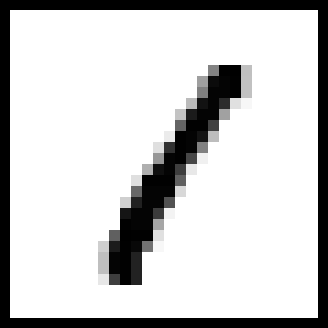

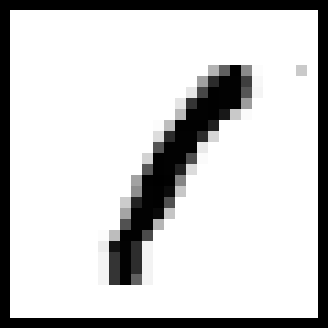

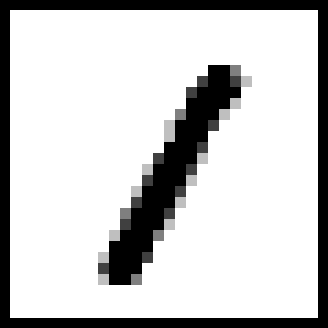

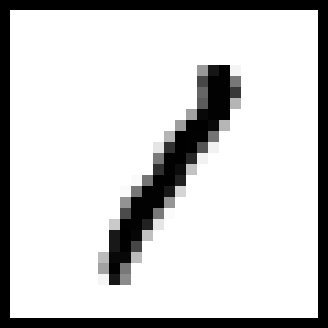

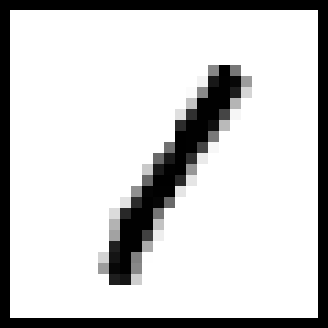

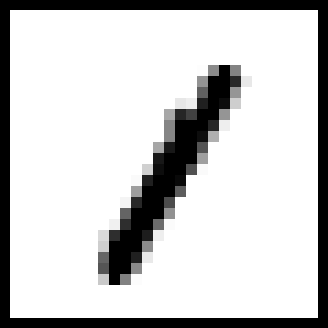

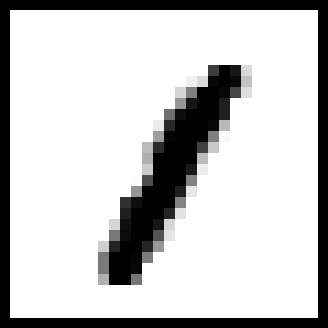

In [446]:
plot_digit(X, 3)
# plot_digit(X, 720)
for id in selected_path_points:
    plot_digit(X, id)